# Test

In [3]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="meta-llama/Llama-3.2-3B-Instruct")
messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe(messages)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'generated_text': [{'role': 'user', 'content': 'Who are you?'},
   {'role': 'assistant',
    'content': 'I\'m an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."'}]}]

# 分词器 Tokenizer

In [4]:
import json
import matplotlib.pyplot as plt

from pathlib import Path
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM

In [5]:
MODLE_BASE_DIR = "/workspace/.hf_home/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95"

In [6]:
model_path = MODLE_BASE_DIR
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
torch_dtype = torch.bfloat16

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 读取模型文件

In [8]:
model_m = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch_dtype)
model_m.to(device)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((3072,), eps=1e-05)
    (rotary_emb

In [9]:
model = model_m.state_dict()

In [10]:
# 模型配置参数
config = model_m.config.to_dict()
print(json.dumps(dict(sorted(config.items())), indent=4))

{
    "_name_or_path": "/workspace/.hf_home/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95",
    "add_cross_attention": false,
    "architectures": [
        "LlamaForCausalLM"
    ],
    "attention_bias": false,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 128000,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dtype": "bfloat16",
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": [
        128001,
        128008,
        128009
    ],
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "head_dim": 128,
    "hidden_act": "silu",
    "hidden_size": 3072,
    "id2label": {
        "0": "LABEL_0",
        "1": "LABEL_1"
    }

In [11]:
dim = config["hidden_size"]
n_layers = config["num_hidden_layers"]
n_heads = config["num_attention_heads"]
n_kv_heads = config["num_key_value_heads"]
vocab_size = config["vocab_size"]
norm_eps = config["rms_norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

group_heads = n_heads // n_kv_heads
dk = dim // n_heads

# 文本分词编码

In [12]:
prompt = "测试中，用中文说成语，前程似锦，金榜题"
# prompt = "中华人民万"
# prompt = "星期"

In [13]:
tokens = tokenizer.encode(prompt, add_special_tokens=True)
print(tokens)
tokens = torch.tensor(tokens)

[128000, 82805, 16325, 119977, 108891, 37687, 13153, 73981, 3922, 25580, 39607, 104409, 127999, 3922, 35330, 121272, 34972]


In [14]:
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

['<|begin_of_text|>', '测试', '中', '，用', '中文', '说', '成', '语', '，', '前', '程', '似', '锦', '，', '金', '榜', '题']


# Token embedding 嵌入

In [15]:
# 最后输出的全连接层
lm_head = model["lm_head.weight"]

In [16]:
# 加载嵌入层
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["model.embed_tokens.weight"])

tensor([[ 1.1292e-02,  9.9487e-03,  1.4160e-02,  ..., -3.5706e-03,
         -1.9775e-02,  5.3711e-03],
        [ 1.3245e-02, -3.8385e-05,  2.2461e-02,  ..., -2.6550e-03,
          3.1738e-02, -1.0681e-03],
        [ 1.9775e-02,  2.0020e-02,  2.8687e-02,  ..., -3.5248e-03,
          3.1433e-03, -7.6294e-03],
        ...,
        [-3.0975e-03,  2.1057e-03,  4.8828e-03,  ..., -2.0905e-03,
         -1.2207e-03, -2.8992e-03],
        [-3.0975e-03,  2.1057e-03,  4.8828e-03,  ..., -2.0905e-03,
         -1.2207e-03, -2.8992e-03],
        [-3.0975e-03,  2.1057e-03,  4.8828e-03,  ..., -2.0905e-03,
         -1.2207e-03, -2.8992e-03]])

In [17]:
token_embeddings_unnormalized = embedding_layer(tokens).to(torch_dtype).to(device)
print(token_embeddings_unnormalized.shape)

torch.Size([17, 3072])


# RMS 归一化

In [18]:
def rms_norm(tensor, norm_weights):
    r_rms = torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)
    x = (tensor * r_rms) * norm_weights
    return x

In [19]:
# 测试归一化
token_embeddings = rms_norm(token_embeddings_unnormalized, model["model.layers.0.input_layernorm.weight"])
print(token_embeddings.shape)

torch.Size([17, 3072])


# 实现注意力机制

In [20]:
print(
    model["model.layers.0.self_attn.q_proj.weight"].shape,
    model["model.layers.0.self_attn.k_proj.weight"].shape,
    model["model.layers.0.self_attn.v_proj.weight"].shape,
    model["model.layers.0.self_attn.o_proj.weight"].shape,
)

torch.Size([3072, 3072]) torch.Size([1024, 3072]) torch.Size([1024, 3072]) torch.Size([3072, 3072])


## 计算 query

In [21]:
q_layer0 = model["model.layers.0.self_attn.q_proj.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
print(q_layer0.shape)

torch.Size([24, 128, 3072])


## 第一层的第一个头

In [22]:
q_layer0_head0 = q_layer0[0]
print(q_layer0_head0.shape)

torch.Size([128, 3072])


In [23]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
print(q_per_token.shape)

torch.Size([17, 128])


# 位置编码

In [24]:
import numpy as np

In [25]:
def get_position_encoding(seq_len, d_model):
    """生成位置编码
    param seq_len: 序列长度
    param d_model: 词嵌入的纬度
    return: 位置矩阵编码 [seq_len, d_model]
    """
    position = np.arange(seq_len)[:, np.newaxis] # [seq_len, 1]
    print(f"{position=}")

    k = np.arange(d_model // 2)
    print(f"{k=}")
    div_term = 10000 ** (2 * k / d_model) # [d_model // 2]

    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(position / div_term) # 偶数位置
    pe[:, 1::2] = np.cos(position / div_term) # 奇数位置

    return torch.tensor(pe, dtype=torch.float32)

In [26]:
get_position_encoding(seq_len=6, d_model=8)

position=array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])
k=array([0, 1, 2, 3])


tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
          9.9995e-01,  1.0000e-03,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
          9.9980e-01,  2.0000e-03,  1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  2.9552e-01,  9.5534e-01,  2.9996e-02,
          9.9955e-01,  3.0000e-03,  1.0000e+00],
        [-7.5680e-01, -6.5364e-01,  3.8942e-01,  9.2106e-01,  3.9989e-02,
          9.9920e-01,  4.0000e-03,  9.9999e-01],
        [-9.5892e-01,  2.8366e-01,  4.7943e-01,  8.7758e-01,  4.9979e-02,
          9.9875e-01,  5.0000e-03,  9.9999e-01]])

# 旋转位置编码

In [27]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [28]:
zero_to_one_split_into_64_parts = torch.tensor(range(head_dim // 2)) / (head_dim // 2)
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [29]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

In [30]:
freqs_for_each_token = torch.outer(torch.arange(len(token_embeddings_unnormalized)), freqs)

freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
print(freqs_cis)

tensor([[ 1.0000+0.0000e+00j,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          ...,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          1.0000+0.0000e+00j],
        [ 0.5403+8.4147e-01j,  0.6861+7.2746e-01j,  0.7878+6.1596e-01j,
          ...,  1.0000+3.6997e-06j,  1.0000+3.0139e-06j,
          1.0000+2.4551e-06j],
        [-0.4161+9.0930e-01j, -0.0584+9.9829e-01j,  0.2412+9.7048e-01j,
          ...,  1.0000+7.3994e-06j,  1.0000+6.0277e-06j,
          1.0000+4.9103e-06j],
        ...,
        [ 0.1367+9.9061e-01j,  0.3978-9.1749e-01j, -0.9910+1.3396e-01j,
          ...,  1.0000+5.1796e-05j,  1.0000+4.2194e-05j,
          1.0000+3.4372e-05j],
        [-0.7597+6.5029e-01j,  0.9404-3.4018e-01j, -0.8632-5.0488e-01j,
          ...,  1.0000+5.5496e-05j,  1.0000+4.5208e-05j,
          1.0000+3.6827e-05j],
        [-0.9577-2.8790e-01j,  0.8927+4.5066e-01j, -0.3690-9.2942e-01j,
          ...,  1.0000+5.9196e-05j,  1.0000+4.8222e-05j,
          1.0000+3.9282e-05j]])


In [31]:
freqs_cis.shape

torch.Size([17, 64])

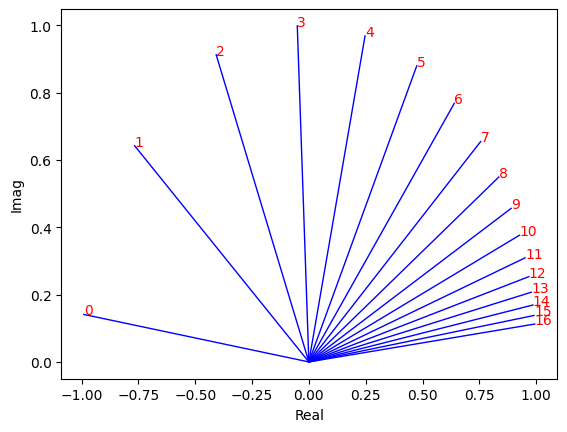

In [32]:
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel("Real")
plt.ylabel("Imag")
plt.show()

In [37]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
print(q_per_token_as_complex_numbers.shape)

torch.Size([17, 64])


In [39]:
q_per_token_as_complex_numbers

tensor([[ 0.0608+0.2539j,  0.1699-0.2100j,  0.0515-0.0386j,  ...,
         -0.0220+0.0243j,  0.2500-0.1279j,  0.0244+0.0693j],
        [ 0.3184+0.2832j,  0.0854-0.3242j,  0.0026-0.1240j,  ...,
          0.0903-1.4297j,  0.8711-0.3301j,  0.6797+1.1484j],
        [ 0.9258+1.0000j,  0.4258-0.7969j,  0.2188-0.3223j,  ...,
         -0.0620-1.6328j,  1.0859-0.7539j,  0.7812+1.7969j],
        ...,
        [-0.1187-0.0859j, -0.1631-0.4160j,  0.1572-0.0253j,  ...,
          0.3652-1.7969j,  1.1484-0.0045j,  0.2598+1.2422j],
        [ 0.0471-0.3516j, -0.1426-0.0081j,  0.0913-0.0216j,  ...,
          0.2539-0.9414j, -0.0386-0.5273j, -0.1187+0.5312j],
        [ 0.4707+0.4004j,  0.0767-0.6289j, -0.0021-0.2188j,  ...,
         -0.1221-1.5234j,  0.7227-0.3770j,  0.6133+1.3594j]], device='cuda:0',
       grad_fn=<ViewAsComplexBackward0>)

In [42]:
# 旋转
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis.to(device)
print(q_per_token_as_complex_numbers_rotated.shape)

torch.Size([17, 64])


In [45]:
# 返回成对的 query
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
print(q_per_token_split_into_pairs_rotated.shape)

torch.Size([17, 64, 2])


In [48]:
# 合并成 query 向量
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
print(q_per_token_rotated.shape)

torch.Size([17, 128])


## 计算 key